# Autoencoders for image quality improvement with Omhu

## Experimenting with CNN6 from Autoencoders.ipynb; main notebook of autoencoders in the project.

In [ ]:
%matplotlib inline
#!pip install torch
#!pip install torchvision
#!pip install torchsummary 

import matplotlib.pyplot as plt
import numpy as np
import random

import torch

cuda = torch.cuda.is_available()

import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torchvision import datasets
import torch.nn as nn

from torchsummary import summary

#from google.colab import drive
#from google.colab import files

## 1. Loading CIFAR10 dataset

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])

# Load dataset
trainset = torchvision.datasets.CIFAR10(root='./data', download =True, train=True, transform = transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform = transform)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

used_categories = range(len(classes))

## USE CODE BELOW IF YOUR COMPUTER IS TOO SLOW
reduce_dataset = False
if reduce_dataset:
    used_categories = (3,5)

    new_train_data = []
    new_train_labels = []

    new_test_data = []
    new_test_labels = []
    for i, t in enumerate(used_categories):
        new_train_data.append(trainset.data[np.where(np.array(trainset.targets) == t)])
        new_train_labels += [i for _ in range(new_train_data[-1].shape[0])]

        new_test_data.append(testset.data[np.where(np.array(testset.targets) == t)])
        new_test_labels += [i for _ in range(new_test_data[-1].shape[0])]
        

    new_train_data = np.concatenate(new_train_data, 0)
    trainset.data = new_train_data
    trainset.targets = new_train_labels

    new_test_data = np.concatenate(new_test_data, 0)
    testset.data = new_test_data
    testset.targets = new_test_labels
    
trainloader = torch.utils.data.DataLoader(trainset, batch_size=200,
                                          shuffle=True, num_workers=2, pin_memory=cuda)
testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                         shuffle=True, num_workers=2, pin_memory=cuda)

train_data_iter = iter(trainloader)
test_data_iter = iter(testloader)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Tensor values range:  tensor(0.) tensor(1.)


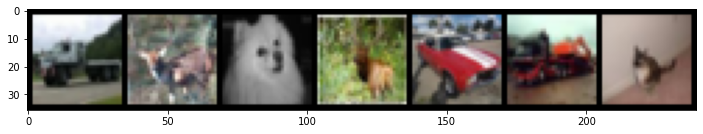

In [ ]:
# Run this cell multiple time to see more samples

def imshow(img, recon=None):
    """ show an image """
    npimg = img.numpy()
    if recon != None: 
      nprecon = recon.detach().numpy()
      fig = plt.figure(figsize=(12, 12))
      ax1 = fig.add_subplot(2,1,1)
      ax1.imshow(np.transpose(npimg, (1, 2, 0)))
      ax2 = fig.add_subplot(2,1,2)
      ax2.imshow(np.transpose(nprecon, (1, 2, 0)))
    else:
      plt.figure(figsize = (12,12))
      plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
images,_ = train_data_iter.next()
print('Tensor values range: ',torch.min(images), torch.max(images))

# show images
imshow(torchvision.utils.make_grid(images[:7]))

### CNN6: CONV (5) + BATCHNORM + UPSAMPLING

In [ ]:
# CONV (5) + BATCHNORM + UPSAMPLING

class Autoencoder_CNN6(nn.Module):
    def __init__(self):
        # N, 3 (channels), 32,32
        super().__init__()
        # Encoder
        self.encoder = nn. Sequential(
            nn.Conv2d(3, 32, 3, stride=1, padding=0), 
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 32, 3, stride=2, padding=0),
            nn.ReLU(),

            nn.Conv2d(32, 32, 3, stride=1, padding=0), 
            nn.BatchNorm2d(32),
            nn.UpsamplingBilinear2d(scale_factor=2),  
            nn.ReLU(),
            
            nn.Conv2d(32, 32, 3, stride=1, padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 3, 1, stride=1, padding=0)) 
            
        
        # Decoder
        self.decoder = nn. Sequential(
            nn.ConvTranspose2d(3, 32, 1), 

            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, 3, stride=1, padding=0, output_padding=0),

            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.UpsamplingBilinear2d(scale_factor=0.5),
            nn.ConvTranspose2d(32, 32, 3, stride=1, padding=0, output_padding=0),

            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, 3, stride=2, padding=0, output_padding=1),
            
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 3, stride=1, padding=0, output_padding=0),

            nn.Sigmoid()
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In Autoencoders.ipynb we runed this model for:
* 50 epoch
* MSE loss
* Batch size = 400
* Adam optimizer
* Learning rate = 1e-3
* Weight decay = 1e-5

and reached a loss of 0.0075.

In [ ]:
model = Autoencoder_CNN6()

if cuda:
    model = model.cuda()

#criterion = nn.MSELoss()
criterion = nn.BCELoss()  #BinaryCrossEntropy

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5) 

In [ ]:
#print(summary(model, (3,32,32)))

# Train the network on transformed data

In [ ]:
  #drive.mount('/content/gdrive')

In [ ]:
num_epochs = 50
outputs = []
orig_ims = []
recon_ims = []
train_loss = []
val_loss = []
color_jitter = transforms.ColorJitter(brightness=2, contrast=0, saturation=0, hue=0)
for epoch in range(num_epochs):
    model.train()
    for (img, _) in trainloader:
        if cuda:
            img = img.cuda()
        if random.uniform(0, 1) < 0.4:
          recon = model(color_jitter(img))
        else:
          recon = model(img)  # get the reconstructed image
        loss = criterion(recon, img)   # calculate the MSE between the original image and the reconstructed image
        
        optimizer.zero_grad() 
        loss.backward()
        optimizer.step()
     
    train_loss.append(loss.item())    

    # Evaluate gradients
    with torch.no_grad():
      model.eval()
    # Just load a single batch from the test loader
      x, _ = next(iter(testloader))
      if cuda:
          x = x.cuda()
      recon_x = model(color_jitter(x))
      loss_x = criterion(recon_x, x)
      val_loss.append(loss_x.item())

    print(f'Epoch:{epoch+1}, Loss:{train_loss[-1]:.4f}, Val_Loss:{loss_x.item():.4f}') 
    if epoch == 0:
        continue

    orig_ims.append(img)  
    recon_ims.append(recon)  
    outputs.append((epoch, x, recon_x)) # store the epoch, the image and the reconstructed image in the outputs list
    if  ((len(train_loss)>1) and (train_loss[-1] < min(train_loss[:-1]))): 
       state_dics = model.state_dict()
       print('new_minloss_epoch: ',epoch+1,' with new_min_loss: ', train_loss[-1]) 
    elif len(train_loss)==1:
      state_dics = model.state_dict()

    

torch.save(state_dics, '/content/best-model-parameters_CNN6_50epoch_200bs_BCELoss.pth')


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


Epoch:1, Loss:0.5808, Val_Loss:0.8621
Epoch:2, Loss:0.5740, Val_Loss:0.5934
new_minloss_epoch:  2  with new_min_loss:  0.5739898085594177
Epoch:3, Loss:0.5750, Val_Loss:0.8786
Epoch:4, Loss:0.5746, Val_Loss:1.0018
Epoch:5, Loss:0.5714, Val_Loss:0.9959
new_minloss_epoch:  5  with new_min_loss:  0.5714429616928101
Epoch:6, Loss:0.5642, Val_Loss:0.9393
new_minloss_epoch:  6  with new_min_loss:  0.5642315745353699
Epoch:7, Loss:0.5675, Val_Loss:0.5890
Epoch:8, Loss:0.5777, Val_Loss:1.3180
Epoch:9, Loss:0.6007, Val_Loss:0.6048
Epoch:10, Loss:0.5597, Val_Loss:1.1937
new_minloss_epoch:  10  with new_min_loss:  0.5596946477890015
Epoch:11, Loss:0.5711, Val_Loss:0.5679
Epoch:12, Loss:0.5718, Val_Loss:1.0251
Epoch:13, Loss:0.5829, Val_Loss:0.6787
Epoch:14, Loss:0.5693, Val_Loss:1.3866
Epoch:15, Loss:0.5564, Val_Loss:2.0267
new_minloss_epoch:  15  with new_min_loss:  0.5564004778862
Epoch:16, Loss:0.5958, Val_Loss:0.9023
Epoch:17, Loss:0.5675, Val_Loss:0.6185
Epoch:18, Loss:0.5723, Val_Loss:1.693

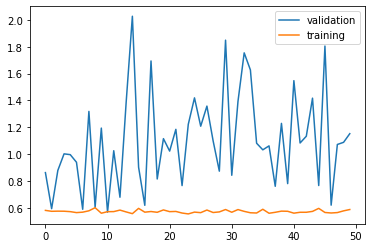

In [ ]:
plt.plot(val_loss, label = "validation")
plt.plot(train_loss, label = "training")
plt.legend()

During the training we have saved the best model we got. With the next line of code we could load any model previously saved to run it on our test data set without the need of training it again. 

In [ ]:
#state_dics = torch.load('/content/best-model-parameters_CNN6_50epoch_200bs_BCELoss.pth')
print(state_dics.keys())

odict_keys(['encoder.0.weight', 'encoder.0.bias', 'encoder.1.weight', 'encoder.1.bias', 'encoder.1.running_mean', 'encoder.1.running_var', 'encoder.1.num_batches_tracked', 'encoder.3.weight', 'encoder.3.bias', 'encoder.5.weight', 'encoder.5.bias', 'encoder.6.weight', 'encoder.6.bias', 'encoder.6.running_mean', 'encoder.6.running_var', 'encoder.6.num_batches_tracked', 'encoder.9.weight', 'encoder.9.bias', 'encoder.10.weight', 'encoder.10.bias', 'encoder.10.running_mean', 'encoder.10.running_var', 'encoder.10.num_batches_tracked', 'encoder.12.weight', 'encoder.12.bias', 'decoder.0.weight', 'decoder.0.bias', 'decoder.1.weight', 'decoder.1.bias', 'decoder.1.running_mean', 'decoder.1.running_var', 'decoder.1.num_batches_tracked', 'decoder.3.weight', 'decoder.3.bias', 'decoder.4.weight', 'decoder.4.bias', 'decoder.4.running_mean', 'decoder.4.running_var', 'decoder.4.num_batches_tracked', 'decoder.7.weight', 'decoder.7.bias', 'decoder.9.weight', 'decoder.9.bias', 'decoder.10.weight', 'decoder

In [ ]:
model.load_state_dict(state_dics)
best_model = model.eval()
best_model = best_model.cuda()
print(best_model)

Autoencoder_CNN6(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2))
    (4): ReLU()
    (5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): UpsamplingBilinear2d(scale_factor=2.0, mode=bilinear)
    (8): ReLU()
    (9): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Conv2d(32, 3, kernel_size=(1, 1), stride=(1, 1))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(32, 32, kernel_size=(3, 3), stride=(1, 1)

# Test the network on test data

Now we need to check if the network has learnt anything at all. We will check this by recreating the clean image that the neural network outputs, and checking it against the original image. Let us display some unseen images:

Desired images:


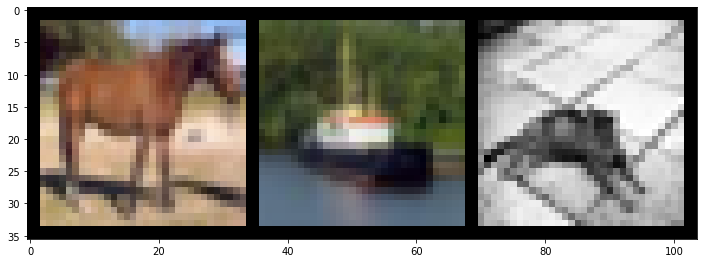

Input images: 


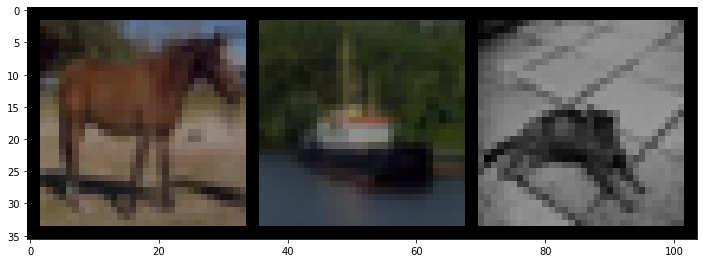

Reconstructed images: 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


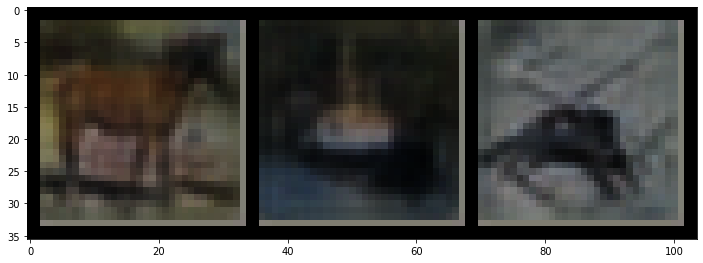

In [ ]:
images, _ = test_data_iter.next()
images.cuda()

# print desired (original) images
print('Desired images:')
imshow(torchvision.utils.make_grid(images[:3]))
plt.show()

# print transformed images: 
print('Input images: ')
transf_images = color_jitter(images)
imshow(torchvision.utils.make_grid(transf_images[:3]))
plt.show()

# print reconstructed images: 
print('Reconstructed images: ')
outputs = best_model(transf_images.cuda()).cpu()
#_, predicted = torch.max(outputs.data, 1)

imshow(torchvision.utils.make_grid(outputs[:3]))